<a href="https://colab.research.google.com/github/mshsu/probasets/blob/main/crashes_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crashes Demo

The exponential distribution can be used to model time between instances of independent, regularly occuring events. Let's look at an example of this in SLO County Vehicle Accidents data. This data is taken from the California Highway Patrol Statewide Integrated Traffic Records System ([CHP-SWITRS](https://iswitrs.chp.ca.gov/Reports/jsp/index.jsp)) public dataset through the Berkeley Transportation Incident Mapping System ([TIMS](https://tims.berkeley.edu/)). Can we model the time between fatal accidents in SLO County using the exponential distribution?

## Setup

In [1]:
!pip install symbulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.8 MB/s eta 0:00:00


In [2]:
from symbulate import *
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [3]:
warnings.filterwarnings("ignore")

## Data

In [4]:
df_crashes = pd.read_csv("https://mshsu.github.io/probasets/data/Crashes.csv")

df_crashes

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y
0,5076937,2011,2012-05-17,9740,2011-01-15,1553,013583,NaN,6,2,...,0,0,-,-,35.510350,-120.623790,SAN LUIS OBISPO,UNINCORPORATED,-120.624356,35.509069
1,5088137,2011,2012-02-22,4003,2011-01-05,1720,C2644,8,3,5,...,0,0,-,-,NaN,NaN,SAN LUIS OBISPO,MORRO BAY,-120.859630,35.391900
2,5097612,2011,2012-04-23,4006,2011-03-23,1508,36190,NaN,3,5,...,0,0,-,-,NaN,NaN,SAN LUIS OBISPO,SAN LUIS OBISPO,-120.661730,35.280600
3,5184048,2011,2012-03-21,4005,2011-01-04,1738,P086,6,2,5,...,0,0,-,-,NaN,NaN,SAN LUIS OBISPO,PISMO BEACH,-120.610700,35.135600
4,5452813,2011,2013-02-06,9745,2011-12-22,2300,13937,NaN,4,3,...,0,0,-,-,35.221450,-120.693170,SAN LUIS OBISPO,UNINCORPORATED,-120.693326,35.220788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10662,9220260,2020,2021-02-26,4004,2020-12-24,1056,1351,NaN,4,5,...,0,0,-,-,35.643280,-120.648727,SAN LUIS OBISPO,PASO ROBLES,-120.640160,35.644547
10663,9236399,2020,2021-03-12,4006,2020-10-27,627,65419,NaN,2,5,...,0,0,-,NF,35.155869,-120.402260,SAN LUIS OBISPO,SAN LUIS OBISPO,-120.673592,35.264633
10664,9248118,2020,2021-04-10,4006,2020-12-28,1751,15913,NaN,1,5,...,0,0,-,-,35.260441,-120.672562,SAN LUIS OBISPO,SAN LUIS OBISPO,-120.672508,35.260605
10665,9258020,2020,2021-05-05,4005,2020-12-26,1827,P115,NaN,6,5,...,0,0,-,-,NaN,NaN,SAN LUIS OBISPO,PISMO BEACH,-120.676308,35.159313


## Wrangling

In [5]:
# Filter to fatal accidents with known times
# 2500 means the time is unknown, according to the data guidebook.
df_small = (df_crashes[(df_crashes['COLLISION_TIME'] != 2500) & (df_crashes['COLLISION_SEVERITY'] == 1)]
            .loc[:, ['CASE_ID', 'COLLISION_DATE', 'COLLISION_TIME']]
            .reset_index(drop=True))

# The time has an inconsistent format.
# For example, 10:30pm will be 2230 (4 digits), 
#   but 7:30am will be 730 (3 digits) when we want it to be 0730,
#   and midnight is 0 when we want it to be 0000.
# This function will fix this error.
def fix_time(i):
  s = str(i)
  if len(s) < 4:
    for i in range(4 - len(s)):
      s = '0' + s
  return s

# Fix our times with the function
df_small['COLLISION_TIME'] = df_small['COLLISION_TIME'].apply(fix_time)
# Calculate the datetime using the date and time variables
df_small['COLLISION_DT'] = pd.to_datetime(df_small['COLLISION_DATE'] + ' ' + df_small['COLLISION_TIME'])
# Get the collision times in milliseconds since the epoch
df_small['COLLISION_MS'] = df_small['COLLISION_DT'].astype(int)
# Sort data chronologically
df_small = df_small.sort_values(by = "COLLISION_DT", ignore_index=True)
# Find the time since the last fatal accident (except for the first one), in milliseconds
time_before = [0] + list(pd.to_numeric(df_small['COLLISION_MS']))[:-1]
df_small["INTERTIME"] = pd.to_numeric(df_small["COLLISION_MS"])-pd.Series(time_before)
df_small["INTERTIME_STR"] = df_small["INTERTIME"].apply(pd.Timedelta)
# Narrow final data down to only what we need
df_small = df_small[['CASE_ID', 'COLLISION_DATE', 'COLLISION_TIME', 'INTERTIME', 'INTERTIME_STR']].iloc[1:]

df_small

,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERTIME,INTERTIME_STR
1,4990915,2011-02-01,0603,2126520000000000,24 days 14:42:00
2,4990533,2011-02-17,1809,1425960000000000,16 days 12:06:00
3,4990595,2011-02-20,2330,278460000000000,3 days 05:21:00
4,4990630,2011-03-01,2310,776400000000000,8 days 23:40:00
5,4990821,2011-03-17,0406,1313760000000000,15 days 04:56:00
...,...,...,...,...,...
273,91354809,2020-10-29,1424,243240000000000,2 days 19:34:00
274,91364500,2020-11-30,1824,2779200000000000,32 days 04:00:00
275,91395681,2020-12-03,0609,215100000000000,2 days 11:45:00
276,91404663,2020-12-03,1422,29580000000000,0 days 08:13:00


## Rate/Average

In [6]:
beta = df_small["INTERTIME"].mean()
lambd = 1/(beta/(1000000000*60*60*24))

print('Avg Time btwn Occurrences: %s\nRate: %.4f fatal accidents in SLO County per day'
      % (pd.Timedelta(beta), lambd))

Avg Time btwn Occurrences: 13 days 01:58:50.036101083
Rate: 0.0764 fatal accidents in SLO County per day


## Exponential Distribution

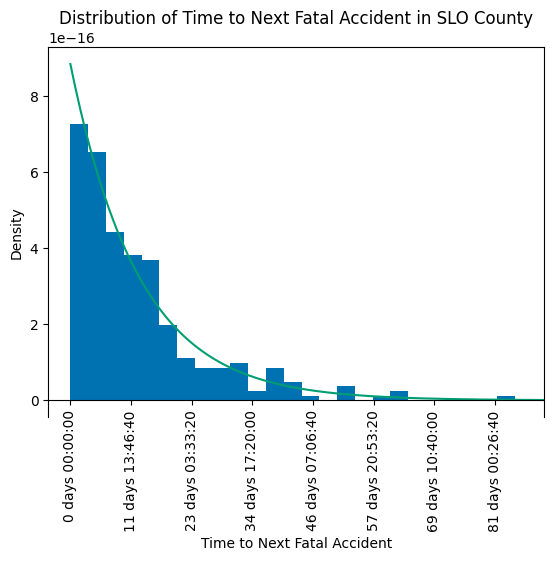

In [7]:
# Plotting the observed data
df_small["INTERTIME"].hist(density=True, bins=25, grid=False)
# Plotting the theoretical distribution
Exponential(rate=1/beta).plot()

# Cosmetic stuff
ax = plt.gca()
plt.ylabel(ylabel="Density")
plt.xlabel(xlabel="Time to Next Fatal Accident")
plt.title(label="Distribution of Time to Next Fatal Accident in SLO County")
xticks = [str(pd.Timedelta(i)) for i in ax.get_xticks()]
ax.set_xticklabels(xticks)
plt.xticks(rotation=90)
xlims = ax.get_xlim()
plt.show()

## Poisson Distribution

In [8]:
# Get frequency of appropriate fatal accidents by date
df_counts = df_small["COLLISION_DATE"].value_counts().to_frame().reset_index().rename(columns={"index": "date", "COLLISION_DATE": "freq"}).sort_values(by="date", ignore_index=True)

# However, the df_counts we just generated doesn't contain days with 0 fatal accidents.
# We need to fix this by generating rows for dates with 0 fatal accidents.
# First, let's find the start and end dates.
start_date = pd.to_datetime(df_counts['date']).min()
end_date = pd.to_datetime(df_counts['date']).max()

# Change the datatype of existing date data to string (for better merging)
df_counts['date'] = df_counts['date'].astype(str)
# Here we generate a dataframe with all dates
all_dates = pd.DataFrame(pd.date_range(start_date, end_date - pd.Timedelta(days = 1), freq='d')).rename(columns={0: 'date'}).astype(str)
# Here we merge the df_counts with the table with all dates
# Then we fill in 0s for dates with no fatal accidents
df_counts = pd.merge(how='left', left=all_dates, right=df_counts, on='date').fillna(0)
df_counts['freq'] = df_counts['freq'].astype(int)

df_counts

,date,freq
0,2011-02-01,1
1,2011-02-02,0
2,2011-02-03,0
3,2011-02-04,0
4,2011-02-05,0
...,...,...
3594,2020-12-04,0
3595,2020-12-05,0
3596,2020-12-06,0
3597,2020-12-07,0


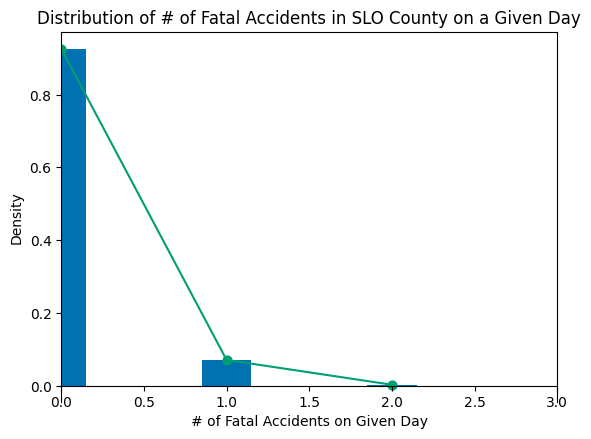

In [9]:
# This makes it so our histogram bar centers line up with the dots on the theoretical distribution
bin_edges=[i+0.5 for i in list(range(min(df_counts["freq"])-1, max(df_counts["freq"])+1, 1))]

# This is the number of days in our timeframe
t=1
# This is our Poisson parameter mu
mu=lambd*t

# Plotting the observed data
df_counts["freq"].hist(density=True, bins=bin_edges, rwidth=0.3, grid=False)
# Plotting the theoretical distribution
Poisson(mu).plot()

# Cosmetic stuff
plt.ylabel(ylabel="Density")
plt.xlabel(xlabel="# of Fatal Accidents on Given Day")
plt.title(label="Distribution of # of Fatal Accidents in SLO County on a Given Day")
plt.xlim((0,max(df_counts["freq"])+1))
plt.show()